# Zipline Backtest with Single Factor 

This notebook develops and test a simple mean-reversion factor that measures how much recent performance has deviated from the historical average. Short-term reversal is a common strategy that takes advantage of the weakly predictive pattern that stock price increases are likely to mean-revert back down over horizons from less than a minute to one month.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

We are first going to illustrate the zipline alpha factor research workflow in an offline environment. In particular, we will develop and test a simple mean-reversion factor that measures how much recent performance has deviated from the historical average. 

Short-term reversal is a common strategy that takes advantage of the weakly predictive pattern that stock price increases are likely to mean-revert back down over horizons from less than a minute to one month.

To this end, the factor computes the z-score for the last monthly return relative to the rolling monthly returns over the last year. At this point, we will not place any orders to simply illustrate the implementation of a CustomFactor and record the results during the simulation.

After some basic settings, `MeanReversion` subclasses `CustomFactor` and defines a `compute()` method. It creates default inputs of monthly returns over an also default year-long window so that the monthly_return variable will have 252 rows and one column for each security in the Quandl dataset on a given day.

The `compute_factors()` method creates a `MeanReversion` factor instance and creates long, short, and ranking pipeline columns. The former two contain Boolean values that could be used to place orders, and the latter reflects that overall ranking to evaluate the overall factor performance. Furthermore, it uses the built-in `AverageDollarVolume` factor to limit the computation to more liquid stocks

The result would allow us to place long and short orders. We will see in the next chapter how to build a portfolio by choosing a rebalancing period and adjusting portfolio holdings as new signals arrive.

- The `initialize()` method registers the compute_factors() pipeline, and the before_trading_start() method ensures the pipeline runs on a daily basis. 
- The `record()` function adds the pipeline's ranking column as well as the current asset prices to the performance DataFrame returned by the `run_algorithm()` function

Run using jupyter notebook extension

In [4]:
%load_ext zipline

Using the `quandl` bundle instead of the default `quantopian-quandl` because the latter has a bug that requires (manually) fixing the SQL database. If you have a file with benchmark returns you can provide this instead of `--no-benchmark` (see [docs](https://github.com/stefan-jansen/zipline/blob/master/docs/source/whatsnew/1.4.0.txt)).

In [5]:
%%zipline --start 2015-1-1 --end 2018-1-1 --output single_factor.pickle --no-benchmark --bundle quandl

from zipline.api import (
    attach_pipeline,
    date_rules,
    time_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    get_open_orders,
    calendars
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume
import numpy as np
import pandas as pd

MONTH = 21
YEAR = 12 * MONTH
N_LONGS = N_SHORTS = 25
VOL_SCREEN = 1000


class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())


def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs': mean_reversion.bottom(N_LONGS),
                             'shorts': mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))


def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)


def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(context.portfolio.positions.keys()) - set(longs.union(shorts))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS)


def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)
    context.set_commission(commission.PerShare(cost=.01, min_trade_cost=0))
    context.set_slippage(slippage.VolumeShareSlippage())


def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')

,period_open,period_close,returns,starting_value,pnl,capital_used,orders,transactions,positions,ending_exposure,...,algo_volatility,benchmark_period_return,benchmark_volatility,treasury_period_return,alpha,beta,sharpe,sortino,factor_data,prices
2015-01-02 21:00:00+00:00,2015-01-02 14:31:00+00:00,2015-01-02 21:00:00+00:00,0.000000,0.000,0.000000,0.000000e+00,[],[],[],0.000,...,NaN,0.0,NaN,0.0,None,None,NaN,NaN,NaN,NaN
2015-01-05 21:00:00+00:00,2015-01-05 14:31:00+00:00,2015-01-05 21:00:00+00:00,0.000000,0.000,0.000000,0.000000e+00,"[{'id': '23d1b1e0f5f7435393c1da90b7e89fff', 'd...",[],[],0.000,...,0.000000,0.0,0.0,0.0,None,None,NaN,NaN,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
2015-01-06 21:00:00+00:00,2015-01-06 14:31:00+00:00,2015-01-06 21:00:00+00:00,-0.000380,0.000,-3799.475085,-3.118062e+06,"[{'id': '23d1b1e0f5f7435393c1da90b7e89fff', 'd...","[{'amount': 18433, 'dt': 2015-01-06 21:00:00+0...","[{'sid': Equity(749 [CVA]), 'amount': 18433, '...",3114262.860,...,0.003482,0.0,0.0,0.0,None,None,-9.165151,-9.165151,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
2015-01-07 21:00:00+00:00,2015-01-07 14:31:00+00:00,2015-01-07 21:00:00+00:00,0.001286,3114262.860,12850.580000,0.000000e+00,[],[],"[{'sid': Equity(749 [CVA]), 'amount': 18433, '...",3127113.440,...,0.011564,0.0,0.0,0.0,None,None,4.933673,18.918320,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
2015-01-08 21:00:00+00:00,2015-01-08 14:31:00+00:00,2015-01-08 21:00:00+00:00,0.006366,3127113.440,63721.760000,0.000000e+00,[],[],"[{'sid': Equity(749 [CVA]), 'amount': 18433, '...",3190835.200,...,0.044725,0.0,0.0,0.0,None,None,8.194658,135.877107,Equity(0 [A]) 2707.0 Equity(2 [AAL]) ...,Equity(0 [A]) 39.800 Equity(2 [AAL])...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22 21:00:00+00:00,2017-12-22 14:31:00+00:00,2017-12-22 21:00:00+00:00,-0.001537,685221.750,-16960.030000,0.000000e+00,[],[],"[{'sid': Equity(672 [CPRT]), 'amount': -10147,...",668261.720,...,0.090139,0.0,0.0,0.0,None,None,0.406793,0.609931,Equity(0 [A]) 2393.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.66 Equity(1 [AA]) ...
2017-12-26 21:00:00+00:00,2017-12-26 14:31:00+00:00,2017-12-26 21:00:00+00:00,-0.003947,668261.720,-43497.970000,0.000000e+00,"[{'id': '69fb365b814747258aeffadf0dc63382', 'd...",[],"[{'sid': Equity(672 [CPRT]), 'amount': -10147,...",624763.750,...,0.090110,0.0,0.0,0.0,None,None,0.391704,0.587086,Equity(0 [A]) 2363.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.25 Equity(1 [AA]) ...
2017-12-27 21:00:00+00:00,2017-12-27 14:31:00+00:00,2017-12-27 21:00:00+00:00,0.003758,624763.750,41248.841483,1.940099e+06,"[{'id': '69fb365b814747258aeffadf0dc63382', 'd...","[{'amount': 10147, 'dt': 2017-12-27 21:00:00+0...","[{'sid': Equity(54 [ADSK]), 'amount': 4230, 'c...",-1274086.885,...,0.090074,0.0,0.0,0.0,None,None,0.405300,0.607626,Equity(0 [A]) 2363.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.25 Equity(1 [AA]) ...
2017-12-28 21:00:00+00:00,2017-12-28 14:31:00+00:00,2017-12-28 21:00:00+00:00,0.002318,-1274086.885,25543.807669,-5.744239e+04,"[{'id': '4151171252e643d7854c8900d1d47317', 'd...","[{'amount': 2082, 'dt': 2017-12-28 21:00:00+00...","[{'sid': Equity(54 [ADSK]), 'amount': 4230, 'c...",-1191100.685,...,0.090023,0.0,0.0,0.0,None,None,0.413599,0.620128,Equity(0 [A]) 2363.0 Equity(1 [AA]) ...,Equity(0 [A]) 67.25 Equity(1 [AA]) ...


## Inspect Results

We can get the result `DataFrame` using `_` which captures the last cell output (only works when you run it right after the above cell)

In [6]:
result = _

In [7]:
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              755 non-null    datetime64[ns, UTC]
 1   period_close             755 non-null    datetime64[ns, UTC]
 2   returns                  755 non-null    float64            
 3   starting_value           755 non-null    float64            
 4   pnl                      755 non-null    float64            
 5   capital_used             755 non-null    float64            
 6   orders                   755 non-null    object             
 7   transactions             755 non-null    object             
 8   positions                755 non-null    object             
 9   ending_exposure          755 non-null    float64            
 10  starting_exposure        755 non-null    float64 

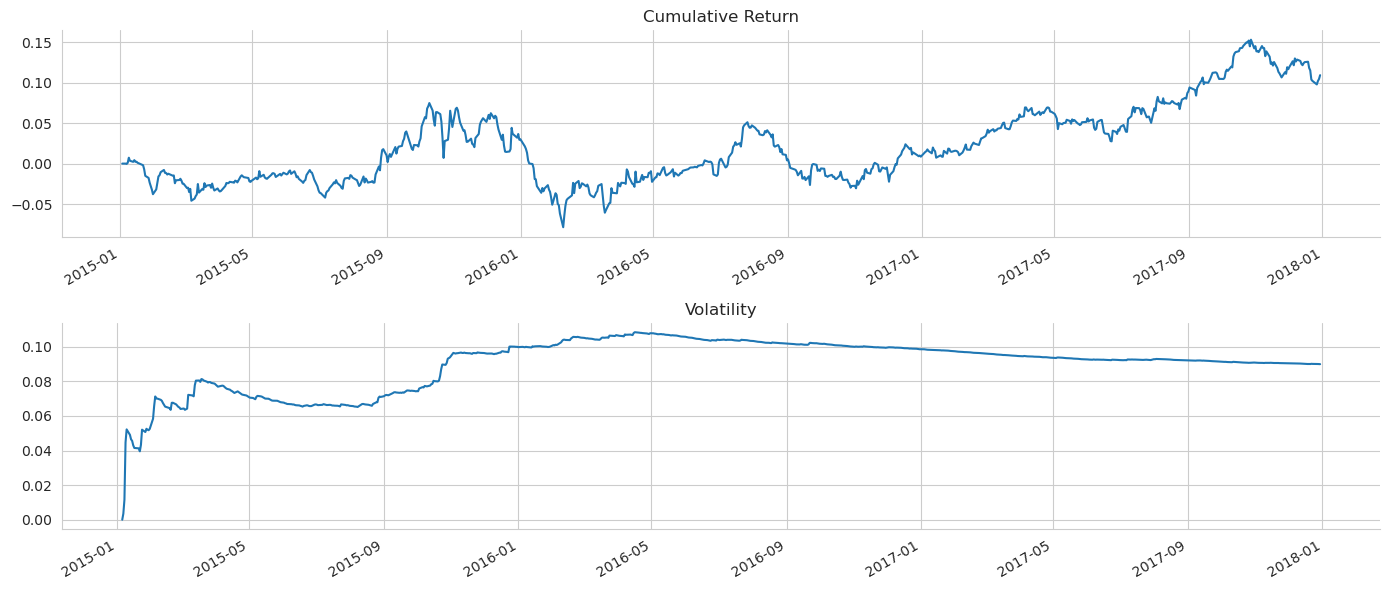

In [8]:
fig, axes = plt.subplots(nrows=2, figsize=(14,6))
result.algorithm_period_return.plot(ax=axes[0], title='Cumulative Return')
result.algo_volatility.plot(ax=axes[1], title='Volatility')
sns.despine()
fig.tight_layout();